In [2]:
import pandas as pd
import geopandas as gpd
import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import folium


In [3]:
# save data
filepath_clean = 'vehicle_registration_info_clean_new.csv'
data = pd.read_csv(filepath_clean, dtype = {'mobile_number': str}, parse_dates=[ 'tax_token_exp_date'])


In [4]:
data.dropna(subset=['registration_office_name'], inplace=True)

In [5]:
keys = ['BANDERBAN', 'BRAHMAN BARIA', 'COXS BAZAR', 'GOPALGONG', 'HABIGONG', 'JHALAKATI', 'JHENIDAH', 'JAIPURHAT', 'KHAGRACHARI', 'KISHOREGONJ', 'LAXMIPUR', 'MANIKGONJ', 'MOULOVI BAZAR', 'NOAOGAON', 'PANCHAGAR', 'SIRAJGONJ', 'SUNAMGONJ']
values = ['Bandarban','Brahamanbaria', "Cox's Bazar", 'Gopalganj', 'Habiganj', 'Jhalokati', 'Jhenaidah', 'Joypurhat', 'Khagrachhari', 'Kishoreganj', 'Lakshmipur', 'Manikganj', 'Maulvibazar', 'Naogaon', 'Panchagarh', 'Sirajganj','Sunamganj']
name_mapping = dict(zip(keys, values))
data['registration_office_name'] = data['registration_office_name'].replace(name_mapping)


In [6]:
dhaka_indices = ['DHAKA DISTRICT', 'DHAKA METRO-1', 'DHAKA METRO-2', 'DHAKA METRO-3', 'DHAKA METRO-4']
chittagong_indices = ['CHATTOGRAM DISTRICT', 'CHATTOGRAM METRO-1',
       'CHATTOGRAM METRO-2', 'CHITTAGONG DISTRICT', 'CHITTAGONG METRO']
total_cars = data.groupby('registration_office_name').count()['tax_token_exp_date']

districts_to_merge = {'Dhaka': dhaka_indices, 'Chittagong': chittagong_indices}

def merge_district_data(main_data: pd.DataFrame, district_names:dict) -> pd.DataFrame:
    df = main_data.groupby('registration_office_name').count()['tax_token_exp_date']
    for district_name in district_names:
       district_list = district_names[district_name]
       df[district_name] = df[district_list].sum()
       df = df.drop(district_list)

    df.index = df.index.str.capitalize()
    df = df.reset_index()
    df.columns = ['District', 'total']
    return df


total_cars_df = merge_district_data(data, districts_to_merge)


In [7]:

expired = data[data['tax_token_exp_date'] < datetime.datetime.now()]

cars = ['CAR (CONVERTIBLE)','CAR (COUPE)','CAR (ESTATE)','CAR (HATCH BACK)','CAR (SALOON)','CAR (SEDAN)','CAR (SPORTS)','CAR(ALLION)']
vans = ['3 WHEEL VAN','CARAVAN','CARGO VAN','CATERING VAN','COVERED VAN','DELIVERY VAN','MOBILE REHABILITATION VAN','MOVIE VAN','PANEL VAN','POLICE VAN','PRISON VAN','REFRIGERATOR VAN','RIOT VAN','SALES VAN','STANDARD VAN','SECURITY VAN','PASSENGER VAN']
trucks = ['CARGO TRUCK (CLOSED)','CARGO TRUCK (OPEN)','MINI TRUCK','TOW TRUCK','TRUCK DEMOUNTABLE','TRUCK DUMP','ARTI. TRUCK (HEAVY)','TRUCK FLATBED','TRUCK LOW BED']
omnibuses = ['OMNIBUS (DUBLEDECK)', 'OMNIBUS (MEDIUM)', 'OMNIBUS (SMALL)', 'OMNIBUS(EXTRA LARGE)', 'OMNIBUS(LARGE)']


dict_of_similar_vehicles = {vehicle: 'Cars' for vehicle in cars}
dict_of_similar_vehicles.update({vehicle: 'Vans' for vehicle in vans})
dict_of_similar_vehicles.update({vehicle: 'Trucks' for vehicle in trucks})
dict_of_similar_vehicles.update({vehicle: 'Omnibuses' for vehicle in omnibuses})

expired['vehicle_type'] = expired['vehicle_type'].replace(dict_of_similar_vehicles)




expired_df = pd.DataFrame(expired.groupby(['registration_office_name', 'vehicle_type']).count()['tax_token_exp_date'])

expired_df = expired_df.reset_index()

dhaka_indices  = ['DHAKA DISTRICT', 'DHAKA METRO-1', 'DHAKA METRO-2', 'DHAKA METRO-3']

# Look for the Dhaka entries and add them on each vehincle type
dhaka = expired_df[expired_df['registration_office_name'].isin(dhaka_indices)].groupby('vehicle_type').sum()
dhaka.drop('registration_office_name', axis=1, inplace=True)
dhaka.columns = ['DHAKA']
chit = expired_df[expired_df['registration_office_name'].isin(chittagong_indices)].groupby('vehicle_type').sum()
chit.drop('registration_office_name', axis=1, inplace=True)
chit.columns = ['CHITTAGONG']

# Concatenate the two dataframes
expired_car_stat_df = pd.concat([dhaka, chit], axis=1)

for distric in expired_df['registration_office_name'].unique():
    df = expired_df[expired_df['registration_office_name'] == distric].groupby('vehicle_type').sum()
    df.drop('registration_office_name', axis=1, inplace=True)
    df.columns = [distric]
    expired_car_stat_df = pd.concat([expired_car_stat_df, df], axis=1)



expired_car_stat_df = expired_car_stat_df.transpose()
expired_car_stat_df.index = expired_car_stat_df.index.str.capitalize()
expired_car_stat_df['count'] = expired_car_stat_df.sum(axis=1)


expired_car_stat_df.fillna(0, inplace=True)
int_cols = expired_car_stat_df.columns




/var/folders/73/zk3nvhcs151155h_b2c87b_c0000gn/T/ipykernel_27676/4248892755.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expired['vehicle_type'] = expired['vehicle_type'].replace(dict_of_similar_vehicles)


In [8]:
liss = []
for col in int_cols:
    liss.append(col)


# save liss to a file
with open('./output/vehicle_types.txt', 'w') as f:
    for item in liss:
        f.write("%s\n" % item)

In [9]:
map = gpd.read_file('bgd_adm_bbs_20201113_SHP/bgd_admbnda_adm0_bbs_20201113.shp')

In [10]:
divisions = gpd.read_file('bgd_adm_bbs_20201113_SHP/bgd_admbnda_adm1_bbs_20201113.shp')

In [11]:
districts = gpd.read_file('bgd_adm_bbs_20201113_SHP/bgd_admbnda_adm2_bbs_20201113.shp')

In [12]:

districts.rename(columns={'ADM2_EN': 'District'}, inplace= True)

districts['District'] = districts['District'].str.capitalize()
districts.set_index('District', inplace=True)

result = pd.merge(districts, expired_car_stat_df, how='left', left_index=True, right_index=True)
result.fillna(0, inplace=True)


result['log(count)'] = result['count'].apply(lambda x: 0 if x == 0 else np.log(x))

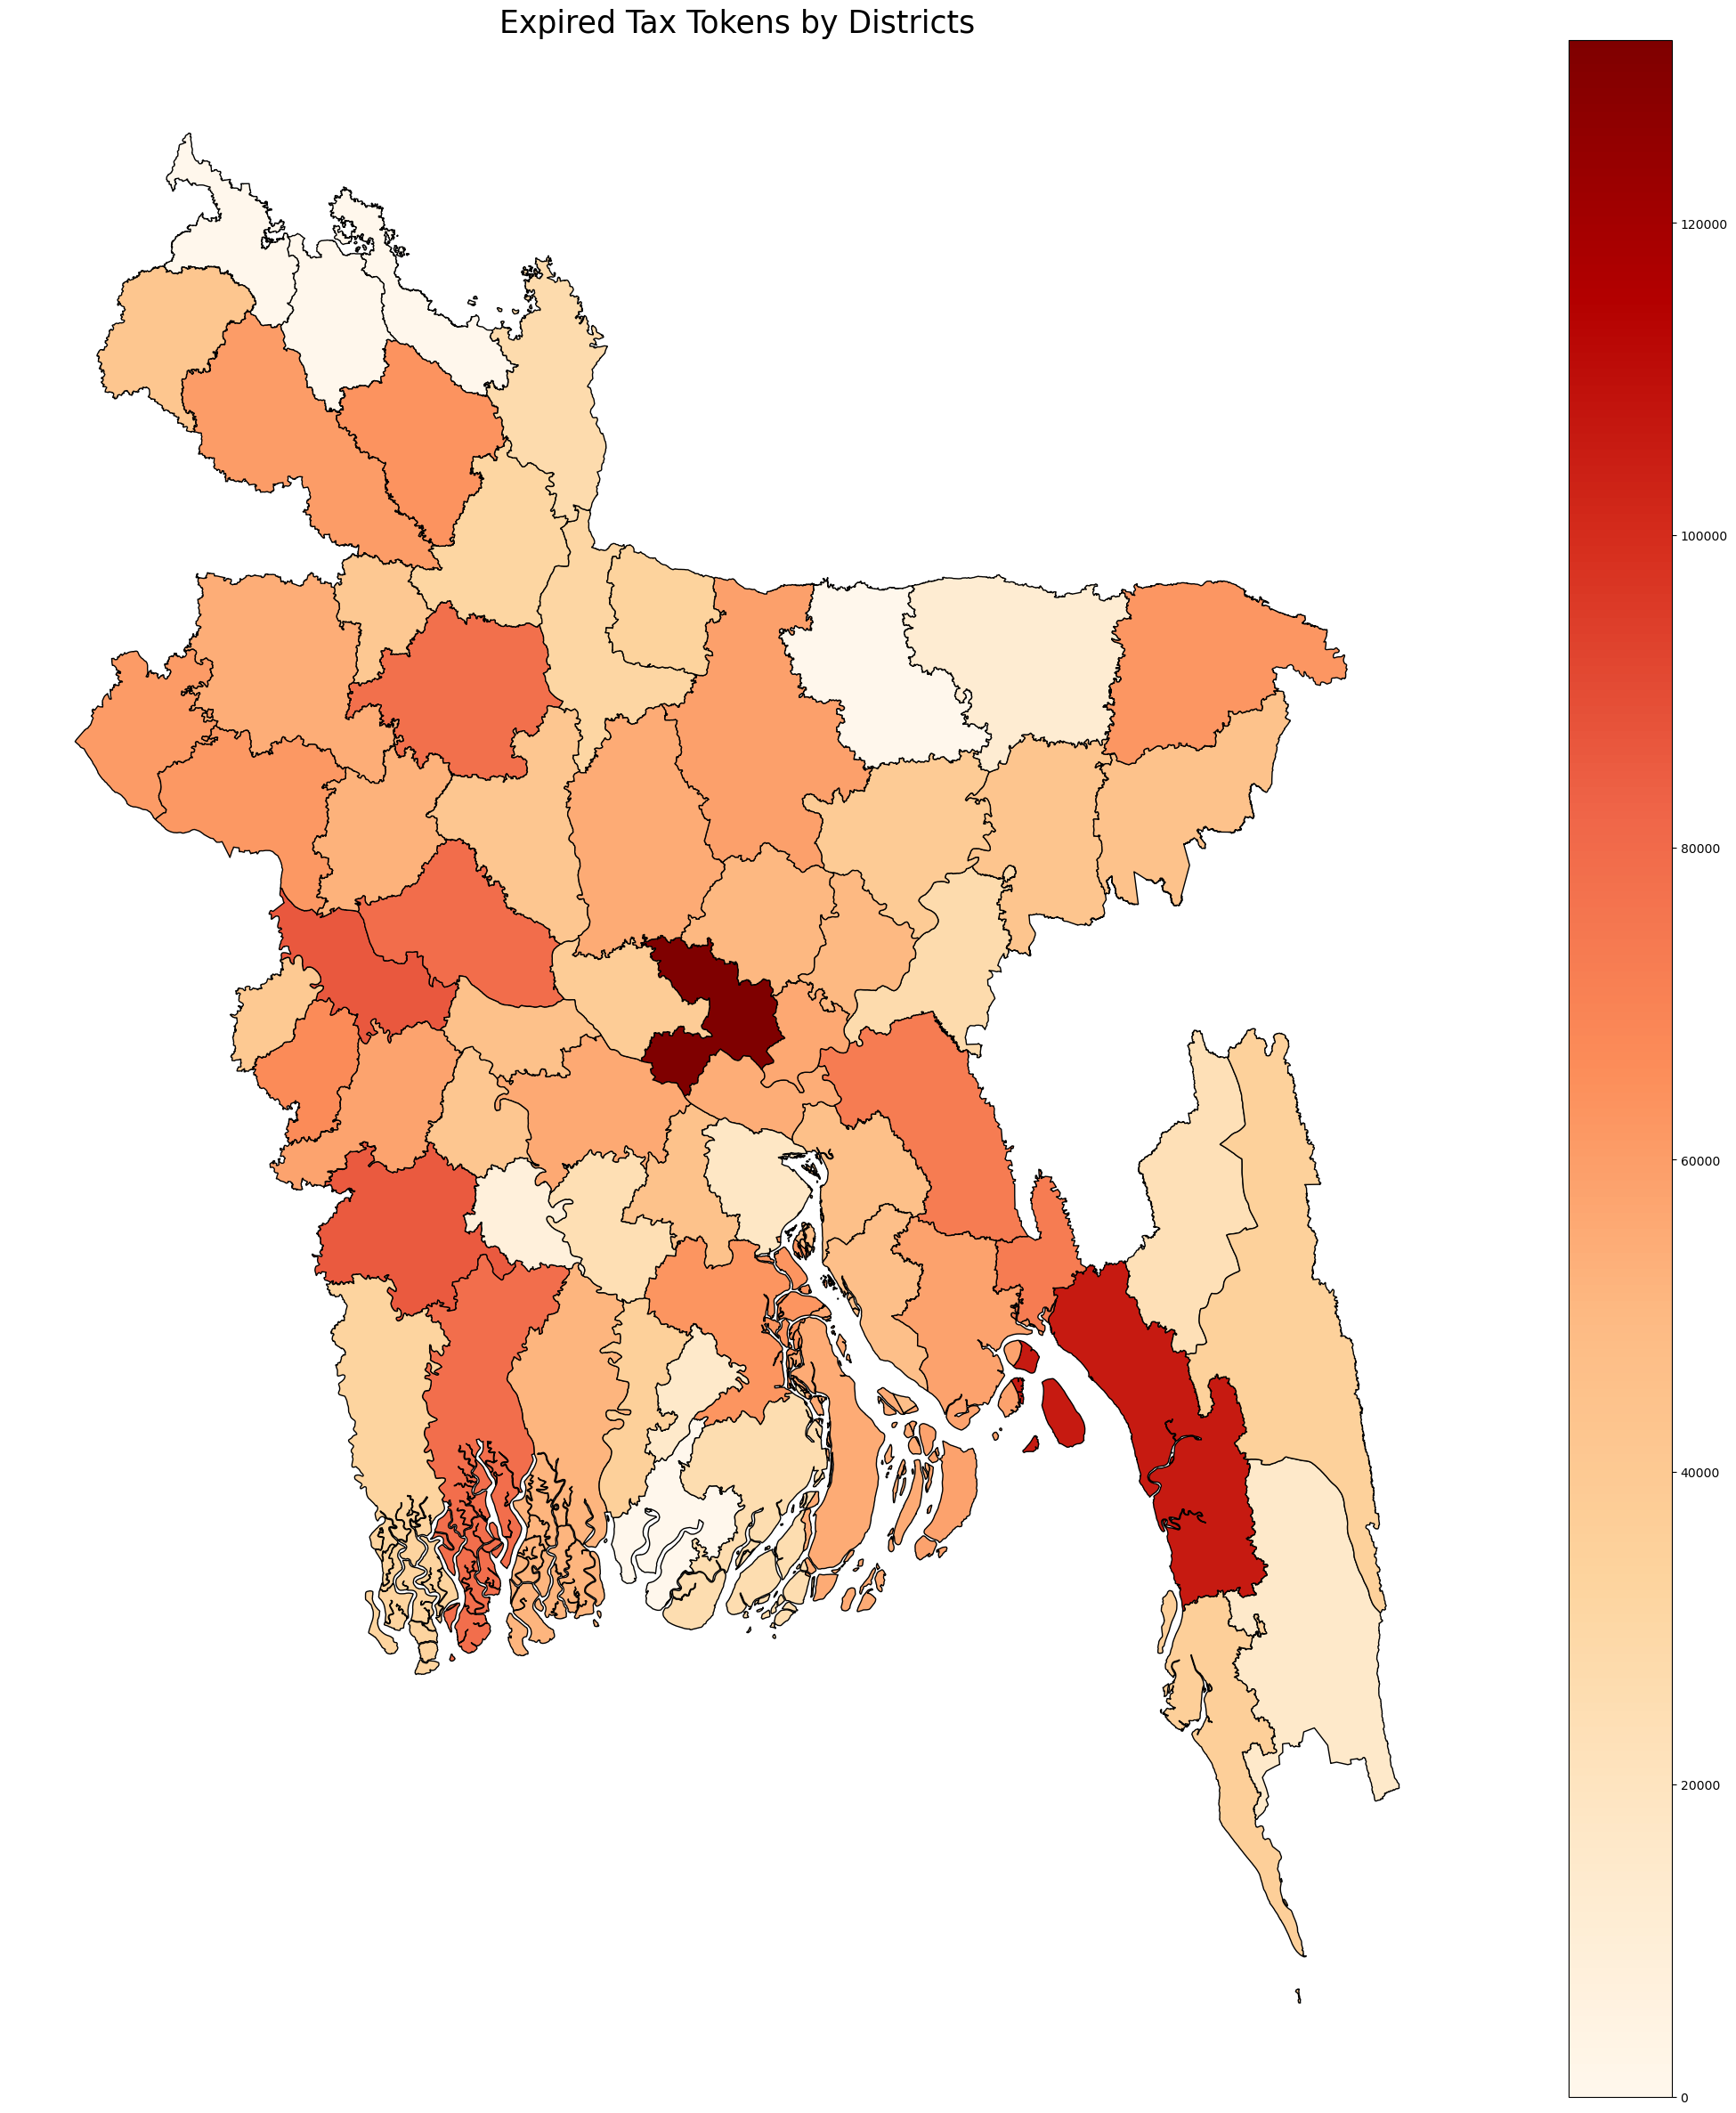

In [13]:

# different color indicates for different division
fig,ax = plt.subplots(figsize=(30,30))

ax = result.plot(ax=ax, cmap = 'OrRd' , edgecolor="black", column='log(count)')
ax.set_title('Expired Tax Tokens by Districts', fontsize=25)

ax.set_axis_off()

# Normalizer and ScalarMappable
norm = mcolors.Normalize(vmin= 0 , vmax=result['count'].max())
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=norm)
sm.set_array([])

# Create the colorbar
cbar = fig.colorbar(sm, ax=ax)



result = result.drop(['ADM2ALT2EN','Shape_Leng', 'Shape_Area','ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'date',
       'validOn', 'ValidTo'], axis=1)


In [14]:
result = pd.merge(result, total_cars_df, on='District', how='left')


In [15]:

result['density'] = result['count']/result['total']


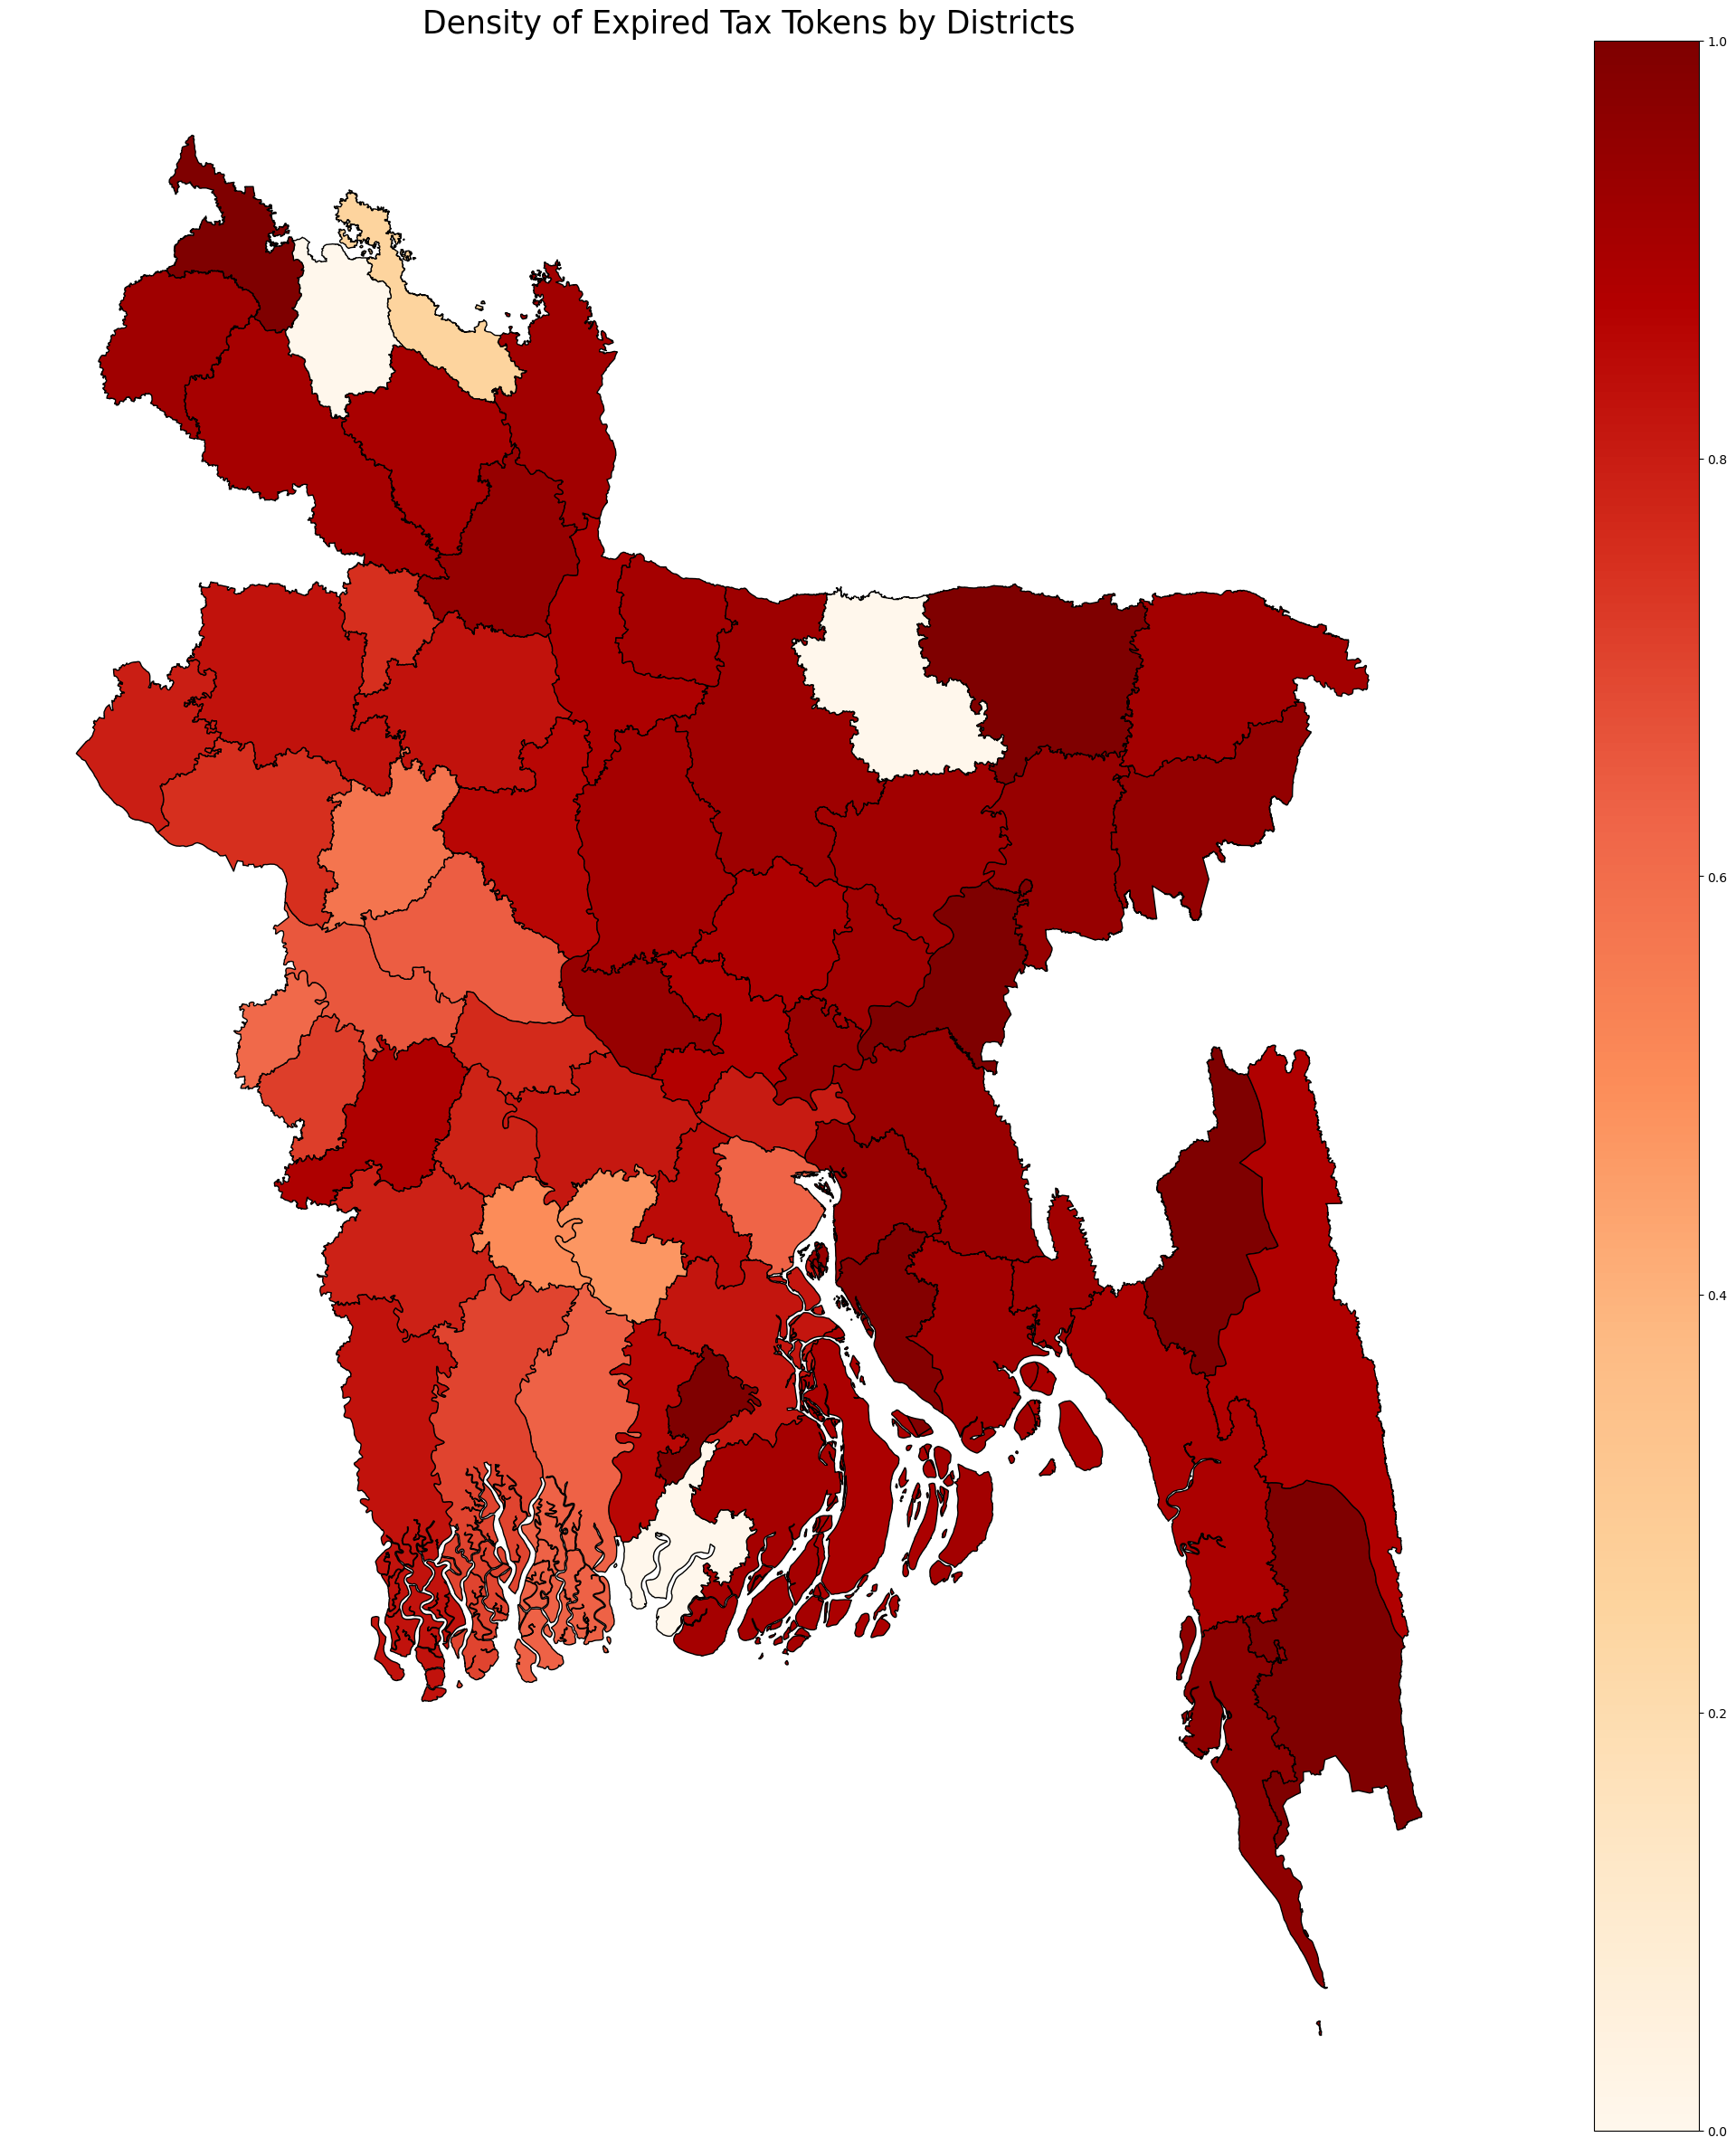

In [16]:

fig,ax = plt.subplots(figsize=(30,30))

ax = result.plot(ax=ax, cmap = 'OrRd' , edgecolor="black", column='density', legend=True)
ax.set_title('Density of Expired Tax Tokens by Districts', fontsize=25)
ax.set_axis_off()


In [17]:

map_view = result.copy()
map_view[int_cols] = map_view[int_cols].astype(int)

map_view.columns = map_view.columns.str.capitalize()
map_view.set_geometry("Geometry", inplace=True)
map_view = map_view.rename(columns={'Count': 'Expired tokens', 'Total' : 'Total no. of cars', 'Density': 'Percentage of expired tokens'})

map_view['Percentage of expired tokens'] = map_view['Percentage of expired tokens'].apply(lambda x: round(x*100, 2))


# map_view.drop(['log(count)'], axis=1, inplace=True)
x = folium.TileLayer("", name="None", attr="blank")

gpd.explore._MAP_KWARGS += ["dragging", "scrollWheelZoom"]

last_three_cols = map_view.columns[-4:]
other_cols = map_view.columns[1:-4]
new_column_order = [map_view.columns[0]] + list(last_three_cols) + list(other_cols)
def generate_tooltip(row):
    tooltip_content = []
    for column in new_column_order:
        if column != 'Geometry' and column != 'Log(count)' and (row[column] != 0 or column == 'Expired tokens' or column == 'Total no. of cars' or column == 'Percentage of expired tokens'):
            if column == 'District':
                tooltip_content.append(f"<strong>{row[column]}</strong> ")
                tooltip_content.append(f"<br>")
            elif column == 'Percentage of expired tokens':
                tooltip_content.append(f"<strong>{column}:</strong> {row[column]}%")
                tooltip_content.append(f"<hr>")
            else:
                tooltip_content.append(f"<strong>{column}:</strong> {row[column]}")
    return '<br>'.join(tooltip_content) if tooltip_content else '<br>'


# Apply the custom tooltip function to each row
map_view[' '] = map_view.apply(generate_tooltip, axis=1)




# Use the 'custom_tooltip' column for the tooltip in your map
map = map_view.explore(column='Percentage of expired tokens', cmap='OrRd', tiles=x,  tooltip = 'District',  legend=True, zoom_control=False, scrollWheelZoom=False, popup=' ')


# save the map
map.save('./output/map.html')

